# DPO Dataset

## Set parameters

In [1]:
# DATASET = "Blended Skill Talk"
# DATASET = "IT-ConvAI2"
DATASET = "FoCus"

LLM_names = [
    "Qwen2-7B-Instruct",
    "Llama3-1-8B-Instruct",
    "Mistral-7B-Instruct"
]

_COT = ""
# _COT = "-COT"

# SCORING_METHOD = "AVG"
SCORING_METHOD = "Length Prioritization"


## Failed Responses

In [2]:
import pandas as pd
import os

# Load the shared prompt data (same for all LLMs)
prompt_path = os.path.join("Prompts", f"{DATASET}.csv")
try:
    prompt_df = pd.read_csv(prompt_path)
    print(f"Loaded prompt data | Shape: {prompt_df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Prompt file not found: {prompt_path}")

# Directory where LLM outputs are stored
base_dir = os.path.join("Raw Responses", DATASET)

# Container for all model outputs (with prompts merged)
all_dfs = []

# Load and horizontally merge prompt data for each LLM file
for LLM_name in LLM_names:
    file_path = os.path.join(base_dir, f"{LLM_name}{_COT}.csv")
    try:
        df = pd.read_csv(file_path)
        if len(df) != len(prompt_df):
            raise ValueError(f"❌ Mismatch in rows: {LLM_name}{_COT}.csv has {len(df)} rows, but prompt file has {len(prompt_df)}.")
        
        df = pd.concat([prompt_df, df], axis=1)  # Horizontal merge
        df["source_model"] = LLM_name + _COT     # Track source model
        print(f" Merged: {LLM_name}{_COT}.csv | New shape: {df.shape}")
        all_dfs.append(df)
    except FileNotFoundError:
        print(f"❌ File not found: {LLM_name}{_COT}.csv")

# Vertically combine all model data
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("\n Final Combined DataFrame shape:", combined_df.shape)
    display(combined_df.head(3))
else:
    print("\n⚠️ No files loaded. combined_df will not exist.")


Loaded prompt data | Shape: (1000, 3)
 Merged: Qwen2-7B-Instruct.csv | New shape: (1000, 6)
 Merged: Llama3-1-8B-Instruct.csv | New shape: (1000, 6)
 Merged: Mistral-7B-Instruct.csv | New shape: (1000, 6)

 Final Combined DataFrame shape: (3000, 6)


,personas,context,act_response,gen_response,response_time,source_model
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,User2: The history of the house you are intere...,"{\n ""response"": ""Nazareth House is a historic...",3.733489,Qwen2-7B-Instruct
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",User2: This house was use as a stop for slaves...,"{\n ""response"": ""This historic home in Jerich...",4.197150,Qwen2-7B-Instruct
2,I am fascinated by the Spanish Colonial Reviva...,"User1: Wow, this is amazing! What is this?\nUs...","User2: Sure, you will like to know that this p...","{\n ""response"": ""The Marion Palace Theatre is...",2.774832,Qwen2-7B-Instruct


In [3]:
import json
import re
import pandas as pd

def clean_gen_response_with_status(cell):
    if not isinstance(cell, str):
        return None, False

    # Step 1: Try full JSON parsing
    json_objects = re.findall(r'\{.*?\}', cell, re.DOTALL)
    for obj in json_objects:
        try:
            parsed = json.loads(obj)
            if "response" in parsed:
                return parsed["response"], True  # ✅ Successfully parsed JSON
        except json.JSONDecodeError:
            continue

    # Step 2: Fallback - Extract string after '"response": "'
    match = re.search(r'"response"\s*:\s*"(.*)', cell, re.DOTALL)
    if match:
        fallback_text = match.group(1)

        # Clean fallback text
        fallback_text = fallback_text.strip('"\n{} ').rstrip('.… ').strip()

        return fallback_text, False  # ❌ Not valid JSON, but usable fallback

    return None, False  # Nothing usable found

# Apply the function
combined_df[["cleaned_response", "json_success"]] = combined_df["gen_response"].apply(
    lambda x: pd.Series(clean_gen_response_with_status(x))
)

# Add word count
combined_df["response_word_count"] = combined_df["cleaned_response"].apply(
    lambda x: len(str(x).split()) if x else 0
)


In [4]:
# Count how many rows have cleaned_response == None
none_count = combined_df["cleaned_response"].isnull().sum()
print(f"Number of None values in 'cleaned_response': {none_count}")


Number of None values in 'cleaned_response': 94


In [5]:
# Drop rows with missing cleaned responses
combined_df = combined_df.dropna(subset=["cleaned_response"])

In [6]:
print("Successful responses:", len(combined_df[combined_df['json_success'] == True]))

print("Failed responses:", len(combined_df[combined_df['json_success'] == False]))

combined_df[combined_df['json_success'] == False].head(4)

Successful responses: 1608
Failed responses: 1298


,personas,context,act_response,gen_response,response_time,source_model,cleaned_response,json_success,response_word_count
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",User2: This house was use as a stop for slaves...,"{\n ""response"": ""This historic home in Jerich...",4.197150,Qwen2-7B-Instruct,"This historic home in Jericho, Vermont has qui...",False,74
3,I want to become a college student.I want to s...,User1: Where is this place?\nUser2: Hello! Wel...,User2: Technische Universität Darmstadt in the...,"{\n ""response"": ""Technische Universität Darms...",4.265017,Qwen2-7B-Instruct,Technische Universität Darmstadt is a renowned...,False,80
4,I like to visit england.I love church.I would ...,User1: Where is this place?\nUser2: This place...,"User2: I suggest a place, for your wish of see...","{\n ""response"": ""Sure, I'd be delighted to he...",4.194262,Qwen2-7B-Instruct,"Sure, I'd be delighted to help you explore mor...",False,85
6,I love nice hotels.I would like to go to Calif...,User1: I think Ive been there before but I don...,User2: Its current owner is Anbang Insurance G...,"{\n ""response"": ""Yes, you can stay at the Wes...",4.224864,Qwen2-7B-Instruct,"Yes, you can stay at the Westin St. Francis to...",False,81


In [7]:
# Step 1: Keep only rows with unsuccessful JSON parsing
rejected_df = combined_df[combined_df["json_success"] == False].copy()

rejected_df.drop(columns=["gen_response", "source_model", "json_success", "response_word_count"], inplace=True)

rejected_df.rename(columns={"cleaned_response": "gen_response"}, inplace=True)

# Step 2: Add default evaluation columns
rejected_df["Coh-UniEval"] = 0.0
rejected_df["C Score"] = -1
rejected_df["UE Score"] = 0
rejected_df["Persona Distance"] = 0.0

# Optional: View result
print(f"✅ Filtered DataFrame shape: {rejected_df.shape}")

print("Columns:", rejected_df.columns)
display(rejected_df.head())

✅ Filtered DataFrame shape: (1298, 9)
Columns: Index(['personas', 'context', 'act_response', 'response_time', 'gen_response',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')


,personas,context,act_response,response_time,gen_response,Coh-UniEval,C Score,UE Score,Persona Distance
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",User2: This house was use as a stop for slaves...,4.197150,"This historic home in Jericho, Vermont has qui...",0.0,-1,0,0.0
3,I want to become a college student.I want to s...,User1: Where is this place?\nUser2: Hello! Wel...,User2: Technische Universität Darmstadt in the...,4.265017,Technische Universität Darmstadt is a renowned...,0.0,-1,0,0.0
4,I like to visit england.I love church.I would ...,User1: Where is this place?\nUser2: This place...,"User2: I suggest a place, for your wish of see...",4.194262,"Sure, I'd be delighted to help you explore mor...",0.0,-1,0,0.0
6,I love nice hotels.I would like to go to Calif...,User1: I think Ive been there before but I don...,User2: Its current owner is Anbang Insurance G...,4.224864,"Yes, you can stay at the Westin St. Francis to...",0.0,-1,0,0.0
7,I have the fantasy about valley.I like lakes.I...,"User1: I know this place, but I dont remember ...",User2: You can view Hat Creek valley and the T...,4.163401,"Sure, the Chaos Crags in Lassen Volcanic Natio...",0.0,-1,0,0.0


In [8]:
# First get unique context-persona pairs
rejected_unique_pairs = rejected_df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(rejected_unique_pairs)}")

rejected_unique_pairs

Total unique context-persona pairs: 743


,personas,context
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs..."
3,I want to become a college student.I want to s...,User1: Where is this place?\nUser2: Hello! Wel...
4,I like to visit england.I love church.I would ...,User1: Where is this place?\nUser2: This place...
6,I love nice hotels.I would like to go to Calif...,User1: I think Ive been there before but I don...
7,I have the fantasy about valley.I like lakes.I...,"User1: I know this place, but I dont remember ..."
...,...,...
2942,I love to vacation in Fort Myers.I am a huge f...,"User1: Wow, this is amazing! What is this?\nUs..."
2954,"I like to visit colorado,I love ballet.I am in...","User1: I know this place, but I dont remember ..."
2965,I would like to go to Donegal.I am not religio...,User1: I think Ive been there before but I don...
2981,I would like to visit Germany.I am interested ...,User1: I think Ive been there before but I don...


## Sucessful Responses

In [9]:
import pandas as pd

all_dfs = []  # List to store all dataframes

for llm in LLM_names:
    # Read the Excel file for each LLM
    ds = pd.read_excel(f"Metrics Results/{DATASET}/{llm}{_COT}-results.xlsx")

    all_dfs.append(ds)

# Combine all dataframes vertically
ds = pd.concat(all_dfs, axis=0, ignore_index=True)
len(ds)

3000

In [10]:
chosen_df = ds.dropna(subset=['gen_response'])

print("Columns:", chosen_df.columns)
print(len(chosen_df))
chosen_df.head(3)

Columns: Index(['personas', 'context', 'act_response', 'gen_response', 'response_time',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')
1355


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,The history of the house you are interested in...,"Nazareth House is an old place, having been co...",3.617683,0.997269,1,1,0.565590
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",This house was use as a stop for slaves trying...,"This historic home in Jericho, Vermont, was na...",3.760247,0.999296,1,0,0.762624
2,I am fascinated by the Spanish Colonial Reviva...,"User1: Wow, this is amazing! What is this?\nUs...","Sure, you will like to know that this place wa...",The Marion Palace Theatre is a stunning exampl...,4.007938,0.998768,1,0,0.776492


## Dataset Creation

In [11]:
print(chosen_df.isna().sum())

print(rejected_df.isna().sum())

personas            0
context             0
act_response        0
gen_response        0
response_time       0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64
personas            0
context             0
act_response        0
response_time       0
gen_response        0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64


In [12]:
# Concatenate chosen_df and rejected_df vertically
df = pd.concat([chosen_df, rejected_df], ignore_index=True)

# Print information about the operation
print(f"Shape of chosen_df: {chosen_df.shape}")
print(f"Shape of rejected_df: {rejected_df.shape}")
print(f"Shape of combined DataFrame: {df.shape}")

# Display the first few rows of the combined dataframe
df.head()

Shape of chosen_df: (1355, 9)
Shape of rejected_df: (1298, 9)
Shape of combined DataFrame: (2653, 9)


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,The history of the house you are interested in...,"Nazareth House is an old place, having been co...",3.617683,0.997269,1,1,0.565590
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",This house was use as a stop for slaves trying...,"This historic home in Jericho, Vermont, was na...",3.760247,0.999296,1,0,0.762624
2,I am fascinated by the Spanish Colonial Reviva...,"User1: Wow, this is amazing! What is this?\nUs...","Sure, you will like to know that this place wa...",The Marion Palace Theatre is a stunning exampl...,4.007938,0.998768,1,0,0.776492
3,I would like to go to University. I live in Mi...,User1: I think Ive been there before but I don...,They offer 132 bachelors degree programs and 1...,Oakland University is a public research instit...,2.222875,0.998187,0,1,0.488114
4,I am willing to start a seminary in New Brunsw...,User1: I think Ive been there before but I don...,It was closely connected with Rutgers Universi...,New Brunswick Theological Seminary was establi...,3.758624,0.998273,0,1,0.751822


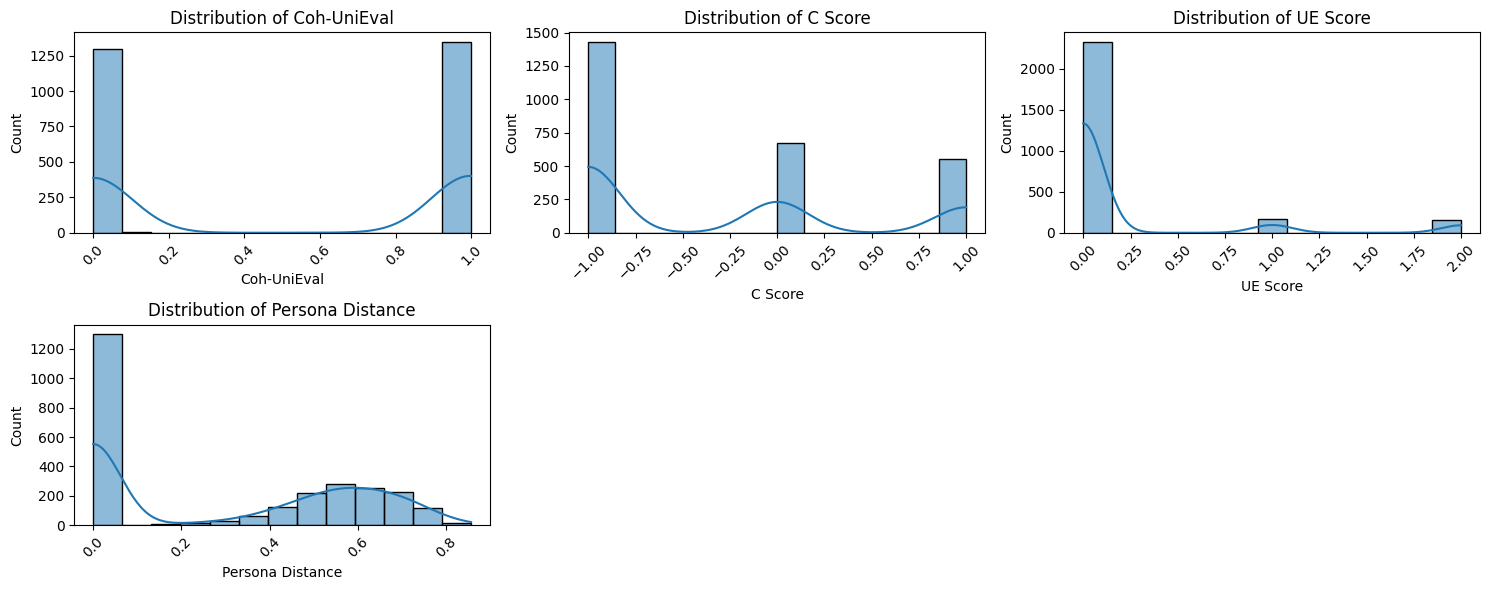

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_analyze = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

plt.figure(figsize=(15, 5*len(columns_to_analyze)//3))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(len(columns_to_analyze)//3 + 1, 3, i)
    sns.histplot(data= df, x=column, kde=True)  # kde=True adds a density curve
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Step 2: Normalize metrics to [0, 1]
metrics = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

scaler = MinMaxScaler()
df[metrics] = scaler.fit_transform(df[metrics])

# Compute response length in number of words
df.rename(columns={"gen_response": "response"}, inplace=True)

df["response_length"] = df["response"].str.split().str.len()

# Set your preferred maximum response length
if _COT == "-COT":
    MAX_LEN = 220
else:
    MAX_LEN = 110

# Compute length penalty (shorter is better)
df["length_penalty"] = 1.0 - (df["response_length"] / MAX_LEN)
df["length_penalty"] = df["length_penalty"].clip(lower=0.0, upper=1.0)


if SCORING_METHOD == "AVG":
    
    # AVG Style
    df["quality_score"] = df[metrics].mean(axis=1)
else:
    
    # Prioritizing the Response Length
    df["quality_score"] = (
        0.15 * df["Coh-UniEval"] +
        0.15 * df["C Score"] +
        0.15 * df["UE Score"] +
        0.15 * df["Persona Distance"] + 
        0.4 * df["length_penalty"]
    )

print("✅ Added normalized quality score:")
display(df[["Coh-UniEval", "C Score", "UE Score", "Persona Distance", "length_penalty", "quality_score"]].head())

df.drop(columns=["Coh-UniEval", "C Score", "UE Score", "Persona Distance", "length_penalty"], inplace=True)

df.drop(columns=["act_response", "response_time", "response_length"], inplace=True)

✅ Added normalized quality score:


,Coh-UniEval,C Score,UE Score,Persona Distance,length_penalty,quality_score
0,0.997432,1.0,0.5,0.659864,0.436364,0.648140
1,0.999460,1.0,0.0,0.889740,0.381818,0.586107
2,0.998933,1.0,0.0,0.905920,0.281818,0.548455
3,0.998351,0.5,0.5,0.569473,0.618182,0.632446
4,0.998437,0.5,0.5,0.877137,0.363636,0.576791


In [15]:
# Function to generate a prompt
def create_dpo_prompt(personas, context, _COT):

    prompt = (
        "I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\n"
        "As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\n"
        "Participant Personas:\n"
        f"{personas}\n\n"
        "Conversation Context:\n"
        f"{context}\n\n"
        "Task Instruction:\n"
        "* Provide an unannotated response.\n"
        "* If only one persona is available, personalize the response accordingly.\n"
        "* If the conversation context is a single query, respond appropriately to the query.\n"
    )
    
    if _COT == "-COT":
        prompt += (
            "* Apply Chain of Thought reasoning to reflect on the alignment of your response with the personas.\n"
        )

    prompt += (
        "\nOutput Format: only give a JSON of the following format:\n"
        "{\n"
    )
    
    if _COT == "-COT":
        prompt += (
            '  "reasoning": "briefly describe your personalization process (in 110 words or less)."\n'
        )
        
    prompt += (
        '  "response": "provide the personalized natural language response here (in 110 words or less)."\n'
        "}\n"
    )

    return prompt

In [16]:
# Step 4: Prepare prompt and extract unique pairs

# # Apply to your dataframe
df["prompt"] = df.apply(lambda row: create_dpo_prompt(row["personas"], row["context"], _COT), axis=1)

# df["prompt"] = df.apply(lambda row: f"Persona: {row['personas']}\nContext: {row['context']}", axis=1)

# Get unique (personas, context) pairs
unique_pairs = df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(unique_pairs)}")

df.head(3)


Total unique context-persona pairs: 1523


,personas,context,response,quality_score,prompt
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,"Nazareth House is an old place, having been co...",0.648140,I will provide you with a conversation context...
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...","This historic home in Jericho, Vermont, was na...",0.586107,I will provide you with a conversation context...
2,I am fascinated by the Spanish Colonial Reviva...,"User1: Wow, this is amazing! What is this?\nUs...",The Marion Palace Theatre is a stunning exampl...,0.548455,I will provide you with a conversation context...


In [17]:
# Step 5: Build DPO dataset with score-chosen and score-rejected
dpo_records = []

for _, pair in unique_pairs.iterrows():
    sub_df = df[
        (df["personas"] == pair["personas"]) &
        (df["context"] == pair["context"])
    ].sort_values("quality_score", ascending=False)
    
    if len(sub_df) >= 2:
        chosen_row = sub_df.iloc[0]
        rejected_row = sub_df.iloc[-1]
        
        dpo_records.append({
            "prompt": chosen_row["prompt"],
            "chosen": chosen_row["response"],
            "rejected": rejected_row["response"],
            "score_chosen": round(chosen_row["quality_score"], 3),
            "score_rejected": round(rejected_row["quality_score"], 3)
        })

print(f"Total DPO records prepared: {len(dpo_records)}")

Total DPO records prepared: 854


In [18]:
# Step 6: Final DataFrame
import pandas as pd

dpo_weighted_df = pd.DataFrame(dpo_records)

print(f"Final weighted DPO dataset shape: {dpo_weighted_df.shape}")

# Save weighted DPO dataset to CSV

if SCORING_METHOD == "AVG":
    output_path = f"dpo_avg{_COT}.csv"
else:
    output_path = f"dpo_length_prior{_COT}.csv"  

dpo_weighted_df.to_csv(f"dpo_datasets/{DATASET}_{output_path}", index=False)

print(f" File saved to: {output_path}")

dpo_weighted_df.head(30)

Final weighted DPO dataset shape: (854, 5)
 File saved to: dpo_length_prior.csv


,prompt,chosen,rejected,score_chosen,score_rejected
0,I will provide you with a conversation context...,"This historic home in Jericho, Vermont, was na...",The Truman Galusha House has been used as a sc...,0.586,0.572
1,I will provide you with a conversation context...,Oakland University is a public research instit...,Oakland University offers a wide range of acad...,0.632,0.491
2,I will provide you with a conversation context...,"The New Brunswick Theological Seminary, which ...",New Brunswick Theological Seminary was establi...,0.751,0.577
3,I will provide you with a conversation context...,"Sure, the National War Memorial is dedicated t...",The National War Memorial is dedicated to the ...,0.686,0.518
4,I will provide you with a conversation context...,Cottage Home Historic District was built in th...,"Cottage Home Historic District, a charming nei...",0.671,0.552
5,I will provide you with a conversation context...,Oakwood theme park has undergone significant t...,"Yes, Oakwood Theme Park has definitely grown o...",0.499,0.494
6,I will provide you with a conversation context...,"Yes, Fort Hamilton does retain some of its def...","As a history enthusiast, I'm intrigued by the ...",0.782,0.563
7,I will provide you with a conversation context...,The Paddington Town Hall is located in the sta...,I'm not particularly fond of living in large b...,0.823,0.807
8,I will provide you with a conversation context...,"I'm not entirely sure, but I believe the new Y...",The new Yankee Stadium was designed by Populou...,0.714,0.494
9,I will provide you with a conversation context...,"Eglinton Castle, located in North Ayrshire, Sc...",As an INFP with a sensitive and imaginative na...,0.649,0.591


# Dataset Concatination

In [19]:
BST = "Blended Skill Talk"
CONVAI = "IT-ConvAI2"
FOCUS = "FoCus"

_COT = ""
# _COT = "-COT"

# SCORING_METHOD = "avg"
SCORING_METHOD = "length_prior"

In [20]:
import pandas as pd

bst_df = pd.read_csv(f"dpo_datasets/{BST}_dpo_{SCORING_METHOD}.csv")
convai_df = pd.read_csv(f"dpo_datasets/{CONVAI}_dpo_{SCORING_METHOD}.csv")
focus_df = pd.read_csv(f"dpo_datasets/{FOCUS}_dpo_{SCORING_METHOD}.csv")

df = pd.concat([bst_df, convai_df], ignore_index=True) 
df.head(3)

,prompt,chosen,rejected,score_chosen,score_rejected
0,I will provide you with a conversation context...,I'm sorry to hear that you experience anxiety....,I think it's because you're worried about how ...,0.711,0.116
1,I will provide you with a conversation context...,"Ha ha, that's hilarious! I can imagine my daug...","Oh no, that must've been quite a surprise! I'm...",0.645,0.564
2,I will provide you with a conversation context...,I'm glad to hear that! I can't wait for your s...,"I'm sure it's bittersweet for you, but it's gr...",0.690,0.530


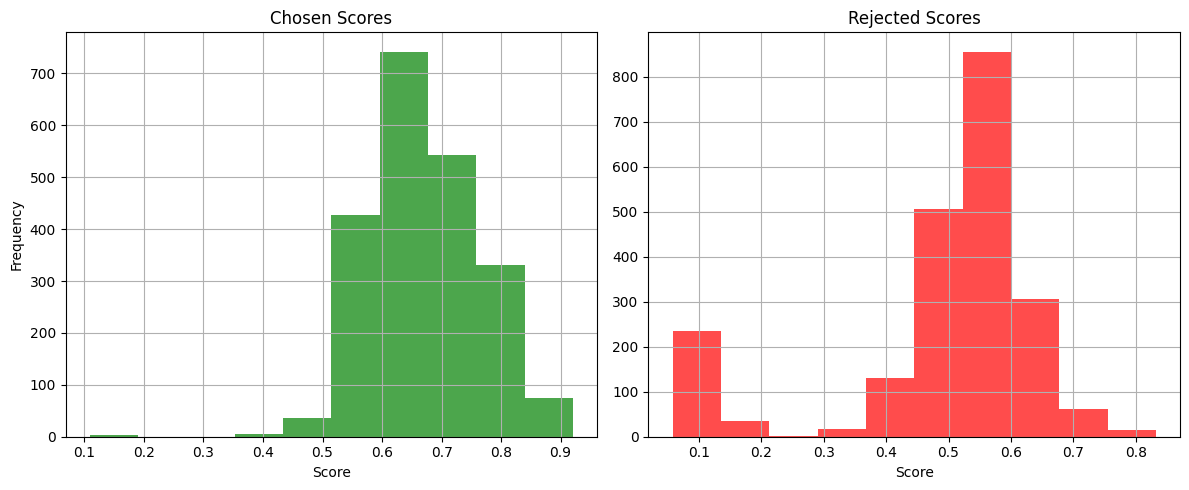

In [21]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms on each subplot
df.score_chosen.hist(ax=ax1, color='green', alpha=0.7)
ax1.set_title('Chosen Scores')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')

df.score_rejected.hist(ax=ax2, color='red', alpha=0.7)
ax2.set_title('Rejected Scores')
ax2.set_xlabel('Score')

# Adjust layout and display
plt.tight_layout()
plt.show()


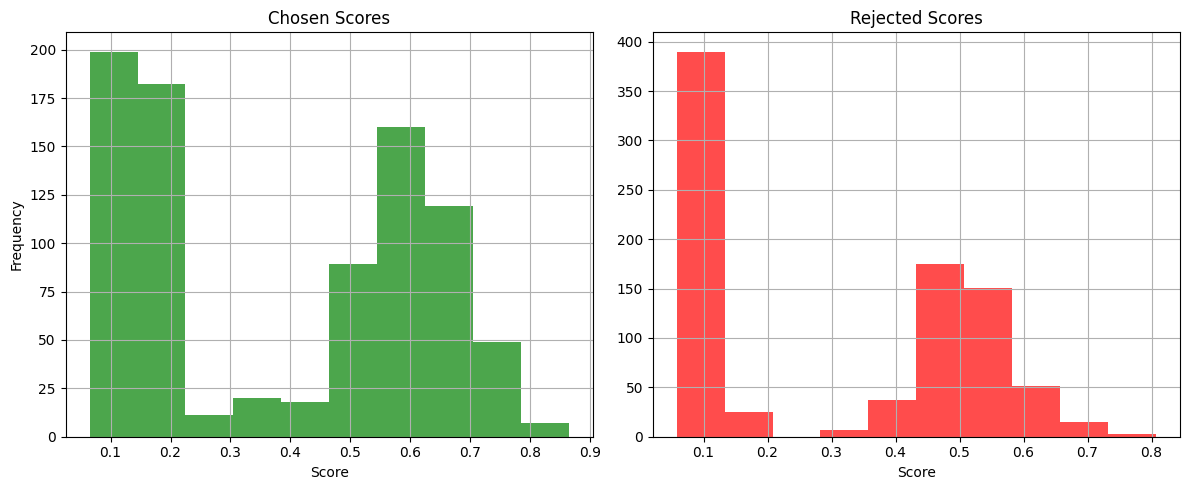

In [22]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms on each subplot
focus_df.score_chosen.hist(ax=ax1, color='green', alpha=0.7)
ax1.set_title('Chosen Scores')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')

focus_df.score_rejected.hist(ax=ax2, color='red', alpha=0.7)
ax2.set_title('Rejected Scores')
ax2.set_xlabel('Score')

# Adjust layout and display
plt.tight_layout()
plt.show()